###  MicroGrad demo

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
np.random.seed(1337)
random.seed(1337)

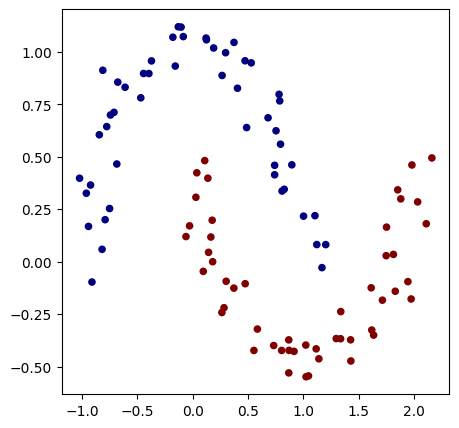

In [13]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [14]:
def unfrozen_info(model):
    fls = [(lid, l) for lid, l in enumerate(model.layers) if not l.frozen]
    if len(fls) == 0:
        return
    params = [(id, n) for id, n in enumerate(fls[0][1].parameters())]
    params = [(fls[0][0], id, p.grad, p.learning_rate, p.learning_rate * p.grad) for id, p in params if p.learning_rate > 0.0]
    params.sort(key=lambda p: p[1])
    return params

In [15]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(2, [8, 32, 8, 1], act='squeeze')
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2), squeeze-Neuron(2)], Layer of [squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8), squeeze-Neuron(8)], Layer of [squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32), squeeze-Neuron(32)], Layer of [linear-Neuron(8)]]
number of 

In [16]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
total_loss.backward()
model.init_lr()

print(total_loss, acc, len(model.parameters()))

Value(data=2.5534797926259576, min=-2.5534797926259576, space=5.106959585251915, pgrad=0.0, grad=1, lr=1.0) 0.22 585


In [21]:
# optimization
for k in range(1000):

    # forward
    total_loss, acc = loss()
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5)

    # if model.freeze():
    #    print('Early Stop by FREEZE!')
    #    break

total_loss, acc = loss()
model.zero_grad()
total_loss.backward()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.7102732153631175, accuracy 99.0%
step 1 loss 0.9187308395391134, accuracy 92.0%
step 2 loss 0.7306425116749333, accuracy 98.0%
step 3 loss 0.7144124607258708, accuracy 99.0%
step 4 loss 0.7777465029663485, accuracy 99.0%
step 5 loss 0.7327293654753954, accuracy 99.0%
step 6 loss 0.7156200156326628, accuracy 99.0%
step 7 loss 0.7206839548499328, accuracy 99.0%
step 8 loss 0.7170255117330159, accuracy 99.0%
step 9 loss 0.708822220595397, accuracy 99.0%
step 10 loss 0.7068333884487813, accuracy 99.0%
step 11 loss 0.704016034713919, accuracy 99.0%
step 12 loss 0.7009547000191078, accuracy 99.0%
step 13 loss 0.718832176172342, accuracy 98.0%
step 14 loss 0.7066319220986778, accuracy 98.0%
step 15 loss 0.6931135405094196, accuracy 99.0%
step 16 loss 0.691290736818925, accuracy 99.0%
step 17 loss 0.6888074503896308, accuracy 99.0%
step 18 loss 0.6905881970778065, accuracy 99.0%
step 19 loss 0.6884427313374137, accuracy 99.0%
step 20 loss 0.6883365726363021, accuracy 99.0%
step 2

In [23]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.data)
parameters

[Value(data=-14.000944284722836, min=-16.10201682850174, space=3.0480970388562802, pgrad=-0.0028001892682238245, grad=0.013338004115431144, lr=0.0007343776040069574),
 Value(data=-6.609360464111169, min=-9.48685986400309, space=4.82842712474619, pgrad=-0.00132187209284202, grad=-0.005895298337281574, lr=7.484224381174526e-08),
 Value(data=-5.065903652030227, min=-10.242640687119287, space=5.176737035089061, pgrad=-0.0010133606271286381, grad=0.23165557995908684, lr=0.8876243943996036),
 Value(data=-4.948515834812975, min=-12.656854249492383, space=8.303300858899114, pgrad=-0.0009897031669625952, grad=-0.03416346820040697, lr=1.0654907698874537e-12),
 Value(data=-4.775541250260304, min=-16.46778756687437, space=12.485281374238573, pgrad=-0.0009551089048968103, grad=0.00361831799440728, lr=0.0034281156116741534),
 Value(data=-4.732410475333505, min=-6.242640687119286, space=3.414213562373095, pgrad=-0.000946482095066701, grad=-0.9152916671088662, lr=2.494072770333958e-21),
 Value(data=-4

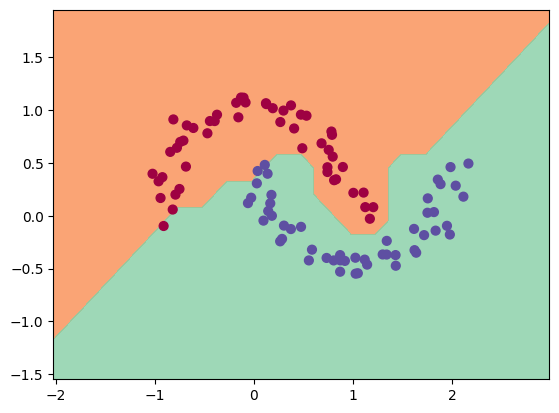

In [24]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visual()

# tanh

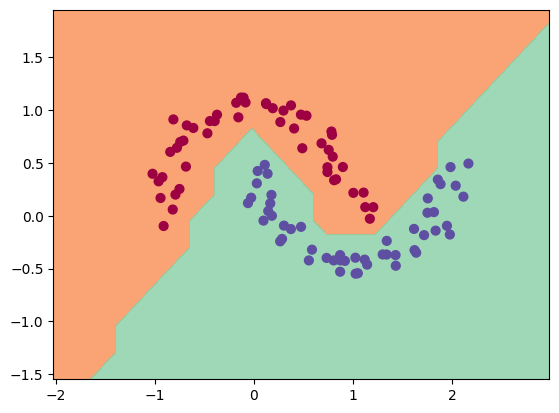

In [8]:
visual()

# relu

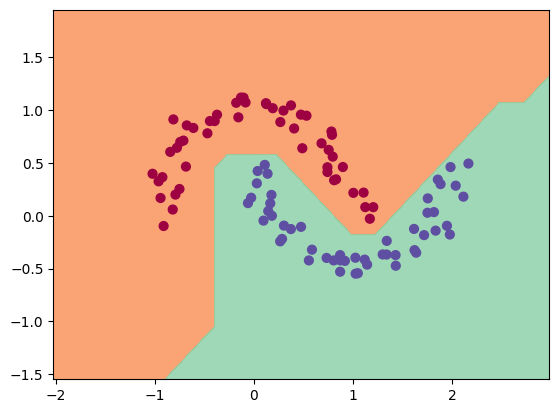

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

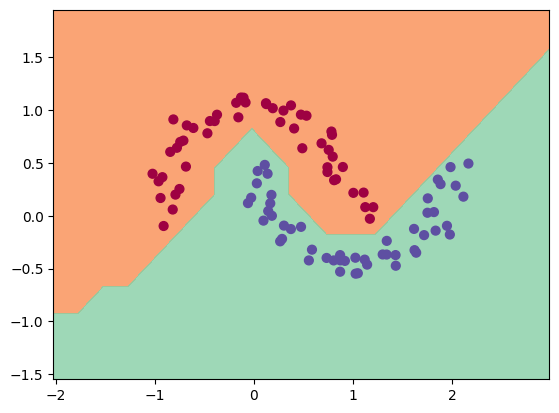

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

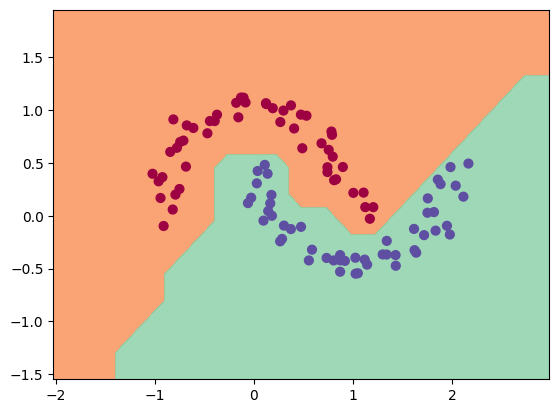

In [22]:
visual()